# GRADIENT DESCENT

## la fonction x²

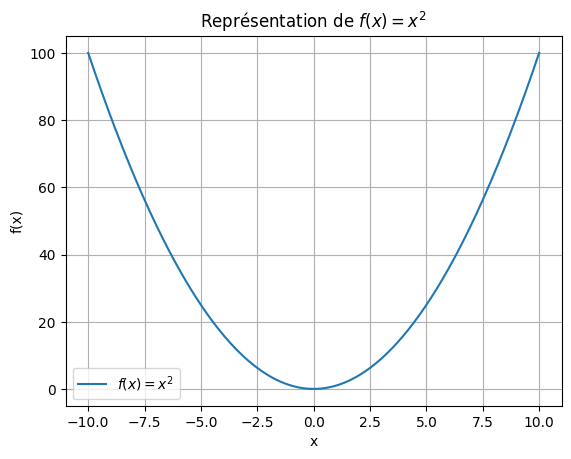

In [543]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return x**2

# On génère des valeurs de x
x = np.linspace(-10, 10, 400)

# calcul des images
y = f(x)

# Créer le graphique
plt.plot(x, y, label='$f(x) = x^2$')
plt.title('Représentation de $f(x) = x^2$')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()


## Pente et tangente

In [544]:
def tx_accroissement(x, dx=1e-4, f=lambda x: x**2):
    return (f(x + dx) - f(x)) / dx

def tangente(x, a, dx=1e-4, f=lambda x: x**2):
    slant = tx_accroissement(a, dx, f)
    print(f"pente théorique : {slant}")
    return slant*(x-a) + f(a)

pente théorique : 4.0001000000078335


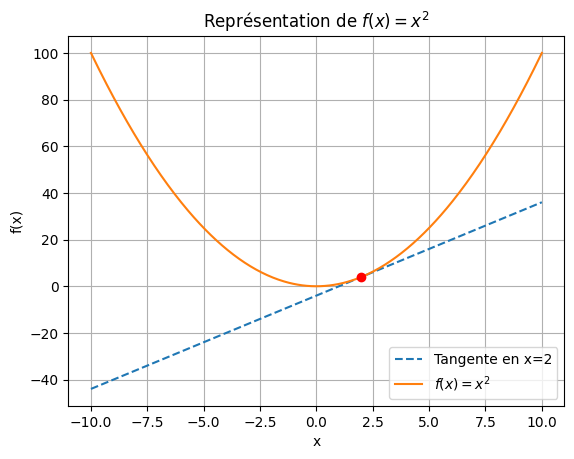

In [545]:
y_tangente = tangente(x, 2)
plt.plot(x, y_tangente, '--', label='Tangente en x=2')

plt.plot(x, y, label='$f(x) = x^2$')
plt.plot(2, f(2), 'ro')
plt.title('Représentation de $f(x) = x^2$')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()


## Calcul de gradient

In [559]:
import numpy as np

def gradient_computation(f, a: np.ndarray, eps: float = 1e-4):
    n = len(a)
    grad_a = np.zeros(n)  # Plus efficace que np.append

    for i in range(n):
        a_eps = a.copy()  # Crée une copie indépendante
        a_eps[i] += eps   # Modifie la i-ème composante
        partial_derivative = (f(a_eps) - f(a)) / eps
        grad_a[i] = partial_derivative
    return grad_a

        


def rosenbrock(a):
    x, y = a[0], a[1]
    return (1 - x)**2 + 100 * (y - x**2)**2

# Test du gradient en [1, 1]
def rosenbrock_derivee(a):
    x, y = a[0], a[1]
    dx = -2*(1-x) -400*x*(y-x**2)
    dy = 200*(y-x**2)
    return [dx, dy]

def nouveau_point(f, a_k:np.array, delta: float, eps: float = 1e-4):
    grad_a_k = gradient_computation(f, a_k, eps)
    new_point = a_k - delta*grad_a_k
    return(new_point)

print(gradient_computation(rosenbrock, np.array([1.,2.])))
print(rosenbrock_derivee(np.array([1.,2.])))


[-399.979896  200.01    ]
[np.float64(-400.0), np.float64(200.0)]


C:\Users\trema\AppData\Local\Temp\ipykernel_9104\3901275990.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad_a[i] = partial_derivative


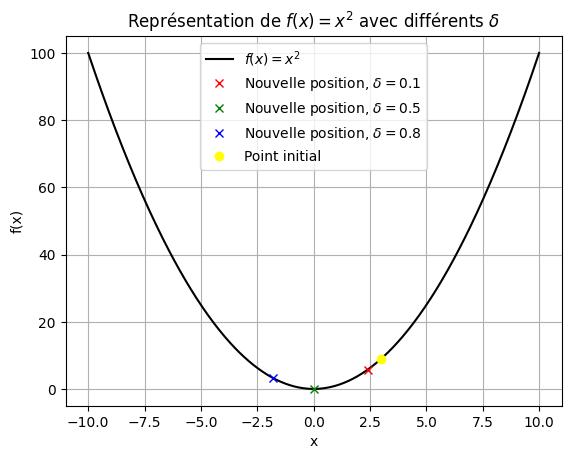

In [547]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return np.array(x)**2

# Configuration des deltas et des couleurs
deltas = [0.1, 0.5, 0.8]
colors = ['red', 'green', 'blue']

# Valeurs pour le tracé
x = np.linspace(-10, 10, 400)
y = f(x)

a_k = np.array([3.0])

plt.plot(x, y, label='$f(x) = x^2$', color='black')

# Tracer les nouveaux points pour chaque delta
for i, delta in enumerate(deltas):
    new_point = nouveau_point(f, a_k, delta)
    plt.plot(new_point[0], f(new_point[0]), 'x', color=colors[i], label=f'Nouvelle position, $\delta={delta}$')

plt.plot(a_k[0], f(a_k[0]), 'o', color='yellow', label='Point initial')

plt.title('Représentation de $f(x) = x^2$ avec différents $\delta$')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()


## Implémentation de la descente de gradient

In [574]:
import numpy as np

def random_point(intervals):
    return np.array([np.random.uniform(low, high) for low, high in intervals])


def gradient_descent(f, intervals: np.array, starting_point: np.array = None,
                     initial_learning_rate: float = 0.4, desc: str = 'constant',
                     max_it: int = 100, max_ecart: float = 1e-4, eps: float = 1e-4,
                     bounded: bool = True):
    
    # Point initial choisi au hasard
    historique = dict()
    historique['x'] = np.zeros((max_it, len(intervals)))
    historique['grad_x'] = np.zeros((max_it, len(intervals)))
    historique['ecart']=np.zeros(max_it)
    if starting_point is None:
        point = random_point(intervals)
    else:
        point = starting_point

    for k in range(max_it):
        grad_point = gradient_computation(f, point, eps)
        ecart = np.linalg.norm(grad_point)

        historique['x'][k]=point
        historique['grad_x'][k]=grad_point
        historique['ecart'][k]=ecart

        if ecart < max_ecart:
            return point, "gradient proche de 0", k+1, historique
        
        if desc == 'linear':
            learning_rate = initial_learning_rate / (k + 1)
        elif desc == 'quad':
            learning_rate = initial_learning_rate / (k + 1) ** 2
        elif desc == 'exp':
            learning_rate = initial_learning_rate * np.exp(-k)
        else:
            learning_rate = initial_learning_rate
        
        point = point - learning_rate*grad_point
        if bounded:
            for i in range(len(point)):
                inf, sup = intervals[i]
                if point[i]<inf:
                    point[i] = inf
                if point[i]>sup:
                    point[i] = sup

    return point, "max itérations atteint", max_it, historique

def gradient_descent_multistart(f, intervals: np.array, n_start: int = 10,
                                initial_learning_rate: float = 0.8, desc: str = 'constant',
                                max_it: int = 100, max_ecart: float = 1e-4, eps: float = 1e-4):
    
    point_min = None
    f_min = np.inf
    for _ in range(n_start):
        starting_point = random_point(intervals)
        point, _, _, _ = gradient_descent(f, intervals, starting_point, initial_learning_rate, desc, max_it, max_ecart, eps)
        if f(point) < f_min:
            point_min = point
            f_min = f(point_min)
    
    return point_min

### Un exemple avec x²

In [562]:
import numpy as np

# Fonction x^2
def quadratic(a):
    return a[0]**2

# Intervalle de recherche pour x
intervals = np.array([[-10, 10]])  # Recherche sur l'intervalle [-10, 10]


# Test avec un seul départ aléatoire
point, message, nb_iterations, hist = gradient_descent(quadratic, intervals= intervals, initial_learning_rate=0.3, desc='constant', max_it=10)
print("Résultat descente de gradient :")
print("Point:", point)
print("Valeur de la fonction:", quadratic(point))
print("Message d'arrêt:", message)
print(nb_iterations)

# Test avec plusieurs départs aléatoires
point_min = gradient_descent_multistart(quadratic, intervals, n_start=5, initial_learning_rate=0.5, desc='linear')
print("\nRésultat descente de gradient multi-start :")
print("Point:", point_min)
print("Valeur de la fonction:", quadratic(point_min))


Résultat descente de gradient :
Point: [-0.00067728]
Valeur de la fonction: 4.5871097439581e-07
Message d'arrêt: max itérations atteint
10

Résultat descente de gradient multi-start :
Point: [-4.99999763e-05]
Valeur de la fonction: 2.4999976305065204e-09


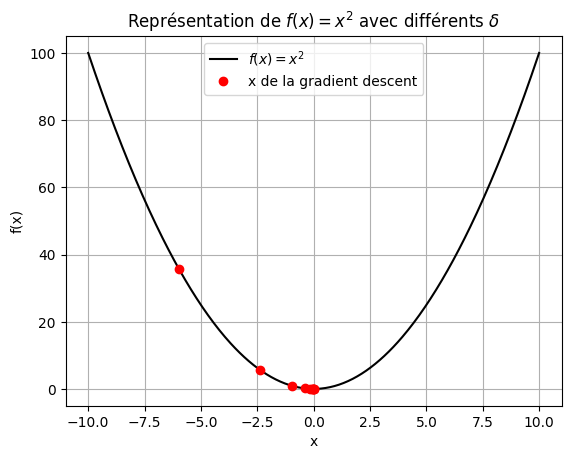

[[-1.19644556e+01]
 [-4.78578224e+00]
 [-1.91431289e+00]
 [-7.65725158e-01]
 [-3.06290063e-01]
 [-1.22516025e-01]
 [-4.90064101e-02]
 [-1.96025640e-02]
 [-7.84102562e-03]
 [-3.13641025e-03]]


In [564]:
# Valeurs pour le tracé
x = np.linspace(-10, 10, 400)
y = x**2
hist_x = hist['x']
x_grad = np.array([float(elt[0]) for elt in hist_x])
y_grad = x_grad**2
plt.plot(x, y, label='$f(x) = x^2$', color='black')
plt.plot(x_grad, y_grad, 'ro', label = "x de la gradient descent")




# plt.plot(a_k[0], f(a_k[0]), 'o', color='yellow', label='Point initial')

plt.title('Représentation de $f(x) = x^2$ avec différents $\delta$')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()

print(hist['grad_x'])

### Un exemple en 2D

In [551]:
def rosenbrock(a):
    x, y = a[0], a[1]
    return (1 - x)**2 + 100 * (y - x**2)**2


# Intervalle de recherche pour x
intervals = np.array([[-2, 2], [-1,3]])  # Recherche sur l'intervalle [-10, 10]


# Test avec un seul départ aléatoire
point, message, nb_iterations, hist = gradient_descent(rosenbrock, intervals, initial_learning_rate=0.001, desc='linear', max_it=100000)
print("Résultat descente de gradient :")
print("Point:", point)
print("Valeur de la fonction:", quadratic(point))
print("Message d'arrêt:", message)
print(nb_iterations)
print("~"*20)

point_min = gradient_descent_multistart(rosenbrock, intervals, n_start=20, initial_learning_rate=0.001, desc='linear', max_it=100000)
print("\nRésultat descente de gradient multi-start :")
print("Point:", point_min)
print("Valeur de la fonction:", quadratic(point_min))



Résultat descente de gradient :
Point: [ 0.12665337 -0.04025584]
Valeur de la fonction: 0.016041075311747744
Message d'arrêt: max itérations atteint
100000
~~~~~~~~~~~~~~~~~~~~

Résultat descente de gradient multi-start :
Point: [1.14017646 1.30061872]
Valeur de la fonction: 1.3000023489012806


## Régression linéaire

On cherche $a$ et $b$ qui minimisent l'erreur quadratique suivante :
$$
\arg \min_{a,b} \left( \sum_{i=1}^{n} \left( y_i - (a x_i + b) \right)^2 \right)
$$


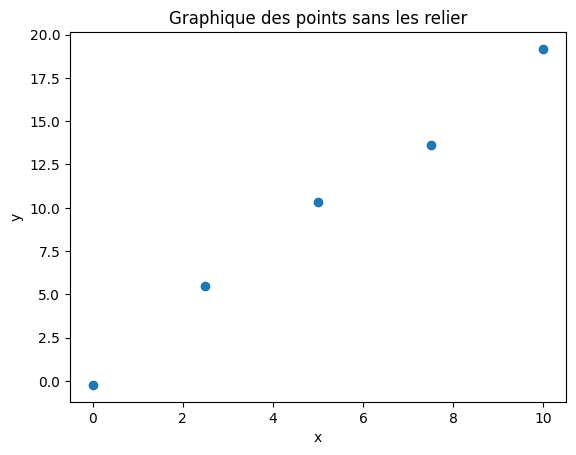

In [552]:
# vrais params
a = 2  
sigma = 1  
n = 5
b = 5
# Génération des valeurs x et y
x = np.linspace(0, 10, n)
eps = np.random.normal(0, sigma, n)
y = a * x + eps


plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Graphique des points sans les relier')
plt.show()

In [553]:
# On définit la fonction de coût
def cout(X:np.array):
    a, b = X
    c = (y - a*x - b)**2
    return c.sum()

In [586]:
# Intervalle de recherche pour x
a = 2  
sigma = 1  
n = 5
b = 5
intervals = np.array([[1, 3], [4,6]]) 


point, message, nb_iterations, hist = gradient_descent(cout, intervals, initial_learning_rate=0.001
                                                       , desc='liear', max_it=10, bounded=False)
print(point)
print(hist['grad_x'])

[-2.14944298e+13  1.04857735e+07]
[[ 6.90087843e+04 -2.27776540e+04]
 [-1.78044969e+06 -4.55553077e+03]
 [ 4.59361971e+07 -9.11254883e+02]
 [-1.18516926e+09 -1.95312500e+02]
 [ 3.05777800e+10  2.00000000e+04]
 [-7.88930560e+11  0.00000000e+00]
 [ 2.03528602e+13 -1.04857600e+10]
 [-5.15396076e+14  0.00000000e+00]
 [ 2.19902326e+16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]]


ValueError: x and y must have same first dimension, but have shapes (10,) and (5,)

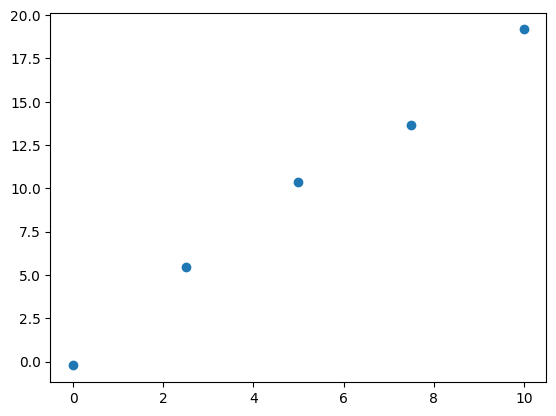

In [555]:
a_est = point[0]
b_est = point[1]
x_plot = np.linspace(0, 10, 10)
y_plot = a_est*x + b_est
plt.scatter(x, y)
plt.plot(x_plot, y_plot, label='régression estimée', color='black')
plt.show()


In [ ]:
import numpy as np

# Vrais paramètres
a = 2
n = 5
b = 5

# Génération des valeurs x et y
x = np.linspace(0, 10, n)
eps = np.random.normal(0, 1, n)
y = a * x + eps

# Fonction de coût
def cout(X: np.array):
    a, b = X
    c = (y - a * x - b)**2
    return c.sum()

# Calcul du gradient pour la régression linéaire
def gradient(a, b, x, y):
    grad_a = -2 * np.sum(x * (y - a * x - b))
    grad_b = -2 * np.sum(y - a * x - b)
    return np.array([grad_a, grad_b])

# Descente de gradient avec taux d'apprentissage linéaire
def gradient_descent(f, gradient, intervals, starting_point=None, initial_learning_rate=0.1, desc='linear', max_it=1000, max_ecart=1e-4, eps=1e-4):
    # Point initial choisi au hasard
    if starting_point is None:
        point = np.random.uniform(intervals[:, 0], intervals[:, 1])
    else:
        point = starting_point

    # Algorithme itératif
    for k in range(max_it):
        grad_point = gradient(point[0], point[1], x, y)  # Calcul du gradient
        ecart = np.linalg.norm(grad_point)
        
        if ecart < max_ecart:
            return point, "Convergence", k

        # Calcul du learning rate
        if desc == 'linear':
            learning_rate = initial_learning_rate / (k + 1)
        elif desc == 'quad':
            learning_rate = initial_learning_rate / (k + 1)**2
        elif desc == 'exp':
            learning_rate = initial_learning_rate * np.exp(-k)
        else:
            learning_rate = initial_learning_rate

        # Mise à jour du point
        point = point - learning_rate * grad_point

    return point, "Max itérations atteint", max_it

# Test de la descente de gradient
intervals = np.array([[1, 5], [2, 8]])  # Intervalle de recherche pour a et b
point, message, nb_iterations = gradient_descent(cout, gradient, intervals, initial_learning_rate=0.01, desc='linear', max_it=10000)
print("Résultat de la descente de gradient :")
print(f"Point: {point}")
print(f"Message d'arrêt: {message}")


Résultat de la descente de gradient :
Point: [1.39306732 3.54228485]
Message d'arrêt: Max itérations atteint
